<a href="https://colab.research.google.com/github/phps-28/Data-Science-PGEBM/blob/master/Mestrado/Projeto/Teste_1_Classifica%C3%A7%C3%A3o_de_Imagens_de_Embri%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introdução

<br>
Este exemplo mostra como fazer a classificação de imagens do zero, começando em arquivos de imagem em JPEG no disco, sem utilizar pesos pré-treinados ou um Keras pré-fabricado
Modelo de aplicação. Demonstramos o fluxo de trabalho no binário Kaggle Cats vs Dogs
 conjunto de dados de classificação.

Usamos o utilitário `image_dataset_from_directory` para gerar os conjuntos de dados, e
usamos camadas de pré-processamento de imagem Keras para padronização de imagens e aumento de dados.

## Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Subindo o arquivo zipado com as imagens

In [ ]:
!unzip -q 100.zip
!ls

100  100.zip  sample_data



 Agora temos uma pasta '100' que contém 7 subpastas. Cada subpasta contem arquivos de imagem de cada categoria.

In [ ]:
!ls 100

AA  CB


### Carregando Imagens


In [ ]:
import os

# Testes com 2 as categorias
num_skipped = 0
for folder_name in ("AA","CB"): # descrevendo as pastas presentes dentro do arquivo main "100"
    folder_path = os.path.join("100", folder_name) # juntando o caminho de cada uma das pastas com o caminho da main pasta(100)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname) # estabelecendo o caminho completo de cada imagem dentro da pasta main e subpastas
        try:
            fobj = open(fpath, "rb") # lendo e abrindo cada uma das imagens
            is_pfif = tf.compat.as_bytes("PFIF") in fobj.peek(10) # verificando a extensão correta das imagens '.png'
        finally:
            fobj.close()

print("Deletadas %d imagens" % num_skipped)

# ----------------------------------------------------------------------------------------------------------------------------------- #
# # Testes com todas as categorias
# num_skipped = 0
# for folder_name in ("AA", "AB", "BA", "BB",	"BC", "CA",	"CB"): # descrevendo as pastas presentes dentro do arquivo main "100"
#     folder_path = os.path.join("100", folder_name) # juntando o caminho de cada uma das pastas com o caminho da main pasta(100)
#     for fname in os.listdir(folder_path):
#         fpath = os.path.join(folder_path, fname) # estabelecendo o caminho completo de cada imagem dentro da pasta main e subpastas
#         try:
#             fobj = open(fpath, "rb") # lendo e abrindo cada uma das imagens
#             is_pfif = tf.compat.as_bytes("PFIF") in fobj.peek(10) # verificando a extensão correta das imagens '.png'
#         finally:
#             fobj.close()

# print("Deletadas %d imagens" % num_skipped)

Deletadas 0 imagens


## Gerando o 'Dataset'

In [ ]:
image_size = (180, 180)
batch_size = 10

# train_ds: dataset de treinamento
# val_ds: dataset de validação (20%)

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "100",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 33 files belonging to 2 classes.
Using 27 files for training.
Using 6 files for validation.


## Visualizando os Dados


Visualizando as classes

In [ ]:
imagens = tf.keras.utils.image_dataset_from_directory("100")
imagens.class_names

Found 33 files belonging to 2 classes.


['AA', 'CB']

* AA = 0
* AB = 1
* BA = 2
* BB = 3
* BC = 4
* CA = 5
* CB = 6




Aqui estão as primeiras 9 imagens do dataset de treino.

In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

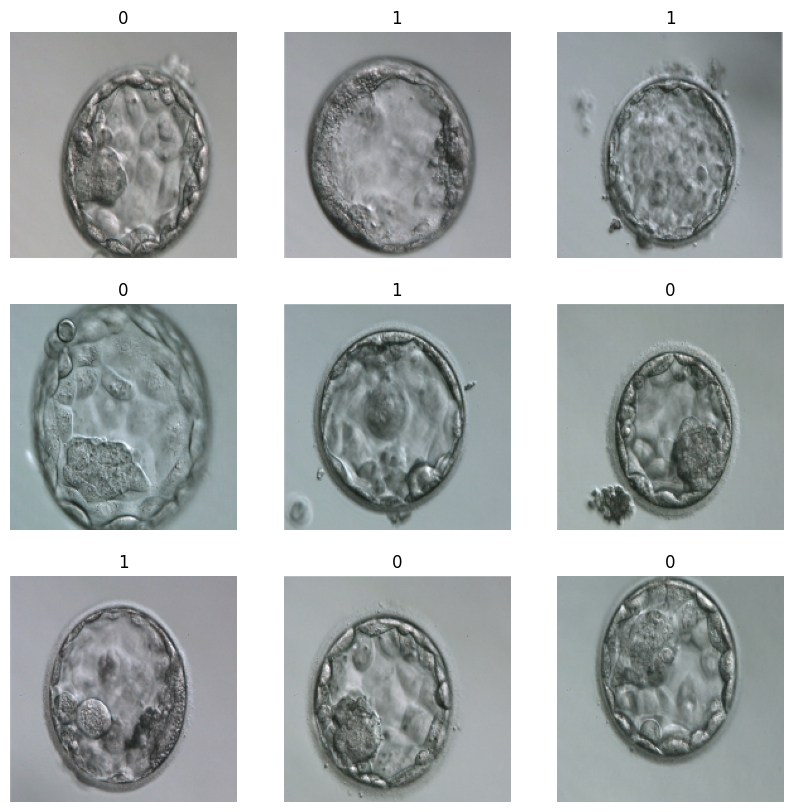

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Usando Aumento de Dados de Imagem
Qdo vc não um grande dataset de imagens, é uma boa prática introduzir artificialmente diversidade de amostras aplicando randomicamente, porém realísticas transformações às imagens de treinamento, como inversões horizontais e pequenas rotações randômicas. Isso ajuda à expor o modelo à diferentes aspectos do datset de treinamento enquanto diminui o overfitting.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
    ]
)

Vamos visualizar o resultado do aumento no número de imagens aplicando o `data_augmentation` repetitivamente à primeira imagem do dataset.

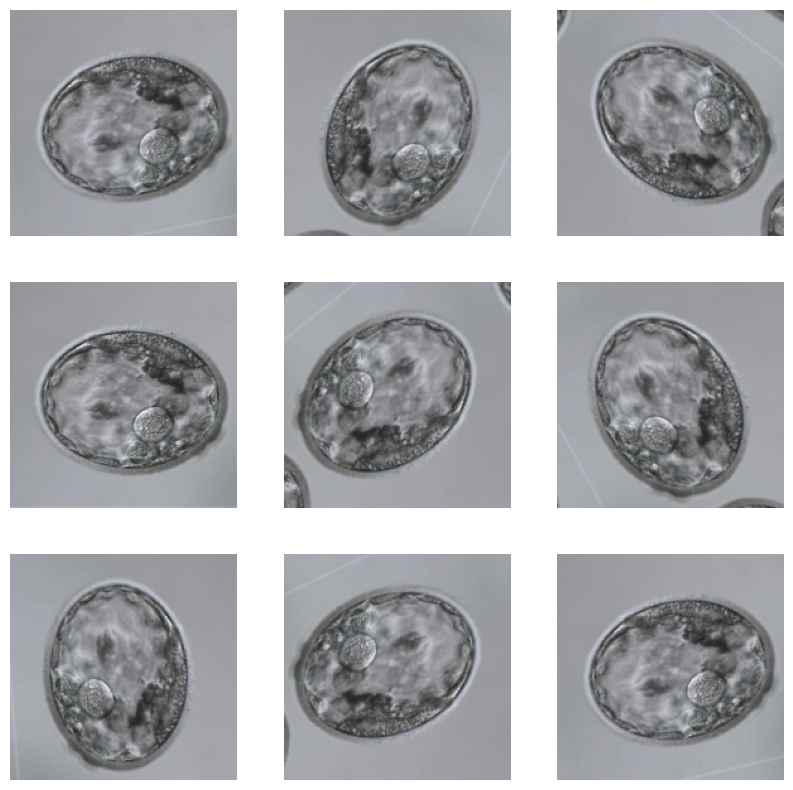

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Normalizando os Dados
Nossa imagem já está em um tamanho padrão (180x180), já que elas já foram geradas como lotes `float32` do nosso dataset. Contudo, seus canais RBG estão com valores entre `[0, 255]`. Isso não é idela para uma rede neural.
<br>
Em geral,  devemos fazer com que nossos valores de input sejam pequenos. Aqui, nós normalizaremos os valores para que sejam entre `[0, 1]` usando uma camada de `Rescaling` no início do nosso modelo.

## Configurando dataset para performance

Aplicando o data augmentation no dataset de treinamento


In [ ]:
# Aplicando `data_augmentation` às imagens de treinamento.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,)

# A pré-busca de amostras na memória da GPU ajuda a maximizar a utilização da GPU.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Construindo o modelo

Construnindo uma pequena versão da rede Xception.


In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
val_ds

(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
# input_shape = (180, 180, 3)
# input_shape

(180, 180, 3)

In [ ]:
# model = tf.keras.Sequential()

# # Camada de Convolução
# model.add(tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', input_shape = input_shape))
# model.add(tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'))
# model.add(tf.keras.layers.MaxPooling2D(2, 2))
# model.add(tf.keras.layers.Dropout(0.3)) # - fazendo a retirada de 30% da base para evitar o overfitting do modelo

# # Camada de Convolução
# model.add(tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', input_shape = input_shape))
# model.add(tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'))
# model.add(tf.keras.layers.MaxPooling2D(2, 2))
# model.add(tf.keras.layers.Dropout(0.3)) # - fazendo a retirada de 30% da base para evitar o overfitting do modelo

# # Camada de Convolução
# model.add(tf.keras.layers.Conv2D(728, (3, 3), activation = 'relu', input_shape = input_shape))
# model.add(tf.keras.layers.Conv2D(728, (3, 3), activation = 'relu'))
# model.add(tf.keras.layers.MaxPooling2D(2, 2))
# model.add(tf.keras.layers.Dropout(0.3)) # - fazendo a retirada de 30% da base para evitar o overfitting do modelo

# model.add(tf.keras.layers.Flatten()) # transformando a imagem convolucionada em um vetor para a entrada na rede densa

# # Camada Densa
# model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
# model.add(tf.keras.layers.Dropout(0.3)) # - fazendo a retirada de 30% da base para evitar o overfitting do modelo

# # Camada Densa
# model.add(tf.keras.layers.Dense(1024, activation = 'relu'))

# # Camada de Saída
# model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

# model.summary()

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(180, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


# image_size = 180
model = make_model(input_shape=image_size + (1,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [ ]:
epochs = 100

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/100


ValueError: ignored

## Rodando o modelo treinado com imagens novas


1/1 [==============================] - 0s 68ms/step
 99.84% AA
 0.16% CB.


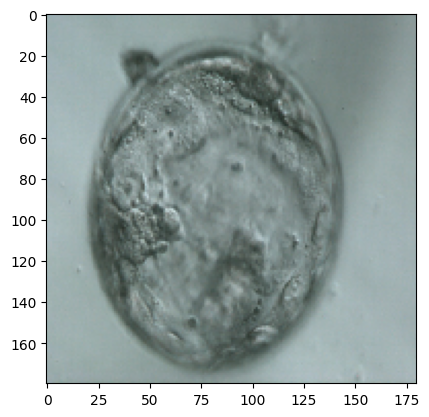

In [ ]:
# # Testes com 2 as categorias

img = keras.utils.load_img(
    "100/CB/4CB 2.PNG", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f" {100 * (1 - score):.2f}% AA\n {100 * score:.2f}% CB.")

# ----------------------------------------------------------------------------------------------------------------------------------- #
# # Testes com todas as categorias

# img = keras.utils.load_img(
#     "100/BB/4BB 10.PNG", target_size=image_size
# )
# plt.imshow(img)

# img_array = keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# predictions = model.predict(img_array)
# score = float(predictions[0])
# print(f" {100 * (1 - score):.2f}% AA\n {100 * score:.2f}% AB\n {100 * score:.2f}% BA\n {100 * score:.2f}% BB\n {100 * score:.2f}% BC\n {100 * score:.2f}% CA\n {100 * score:.2f}% CB.")